## Extra Business Problem
Calculate likelihood of Berlin booking/searching to be performed ( binary classification)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from hyperopt import  tpe, hp,  STATUS_OK
from hyperopt.fmin import fmin
import statistics as st
%matplotlib inline

/home/him/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


## Prepare Train and Validation Datasets

In [2]:
df=pd.read_csv('user_features.csv', header=0,  quotechar='"', error_bad_lines=False)


In [3]:
#is_berlin
berlins=[]
for val in df['destination_BER']:
    if val>0:
        berlin=1
    else:
        berlin=0
    berlins.append(berlin)
df['is_berlin']=berlins

In [4]:
df.head()

,user_id,num_adults,num_children,vac_duration,book_search_duration,book_days_ago,child_per_adult,vac_distance1,vac_distance2,origin_lat,...,origin_YOW,origin_YTO,origin_YUL,origin_YVR,origin_YWG,origin_YYC,origin_YYZ,origin_ZRH,user_id.1,is_berlin
0,000069,2.0,3.0,16.0,10.0,1187.0,1.5,1548.008799,1548.875108,200.32,...,0,0,0,0,0,0,0,0,000069,0
1,00019d,4.0,0.0,28.0,139.0,1188.0,0.0,7932.127859,7951.952030,97.70,...,0,0,0,0,0,0,0,0,00019d,0
2,0002e3,1.0,0.0,0.0,6.0,1192.0,0.0,2107.313051,2104.104322,97.70,...,0,0,0,0,0,0,0,0,0002e3,0
3,000332,1.5,0.0,29.0,41.0,1189.0,0.0,2731.559030,2727.630372,652.34,...,0,0,0,0,0,0,0,0,000332,0
4,0004e1,1.0,0.0,6.0,80.0,1188.0,0.0,709.283337,709.657571,192.98,...,0,0,0,0,0,0,0,0,0004e1,0


In [5]:
y=df['is_berlin']
y=pd.DataFrame(y)
X=df.drop(columns=['is_berlin','destination_BER','user_id','user_id.1','vac_distance1'])

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=7)

## Tunning Lightgbm Parameters With HyperOpt

In [7]:
# try different values in order to prevent overfitting
# change the value according to cross validation results
lr=0.003 # learning_rate value
l1=0.0007 #l1 regularization to prevent overfitting

In [8]:
def error(params):

    dtrain = lightgbm.Dataset(X_train, label=y_train)
    dval = lightgbm.Dataset(X_val, label=y_val, reference=dtrain)

    params = {
         'objective': 'binary', #rank:pairwise', # softmax
         'metric': ['binary_logloss'],
         'learning_rate' : lr,
         'lambda_l1' : l1,
         'boosting': 'gbdt'
        }


    
    evallist = [dtrain, dval]

    num_epochs = 40
    eval_data = {}

    model = lightgbm.train(
        params,
        dtrain,
        num_epochs,
        evallist,
        evals_result=eval_data,
        verbose_eval=True
    )
    #print(eval_data, type(eval_data))
    l=(eval_data['valid_1']['binary_logloss'])
    laerr=min(l)
    #laerr=sum(l) / float(len(l))
    #laerr=l[-1]
    return {'loss':laerr, 'status': STATUS_OK}


space = {
    'max_depth': hp.uniform('max_depth', 1, 6),
    'eta': hp.uniform('eta', 0.1, 0.9),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    #'learning_rate' : hp.uniform('learning_rate', 0.001, 0.07),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    'min_child_weight': hp.loguniform('min_child_weight', -16, 5),
    'feature_fraction': hp.uniform('feature_fraction', 0.3, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.3, 1), 
}


best = fmin(fn=error,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397
[14]	training's binary

[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862       
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322       
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792       
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268       
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766       
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268        
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792       
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279       
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766       
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254       
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767       
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275       
[35]

[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629        
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236        
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937        
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774        
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651        
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593        
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601         
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634        
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714        
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828       
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983       
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174       
[13]

[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245        
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562        
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014       
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428       
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862       
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322       
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792       
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268       
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766       
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268        
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792       
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279       
[31]

[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875       
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447       
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035       
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563        
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634      

[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792 

[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236  

[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245  

[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733  

[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397 

[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279 

[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601   

[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322 

[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629  

[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892 

[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803 

[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174 

[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792 

[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593  

[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862 

[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563  

[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563 

[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275 

[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983 

[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268  

[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651  

[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428 

[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035 

[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237 

[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767 

[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828 

[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766 

[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774  

[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014 

[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447 

[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929 

[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254 

[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937         
[4]	training's binary_logloss: 0.125916	valid_1's binary_logloss: 0.128774         
[5]	training's binary_logloss: 0.124669	valid_1's binary_logloss: 0.127651         
[6]	training's binary_logloss: 0.123508	valid_1's binary_logloss: 0.126593         
[7]	training's binary_logloss: 0.12241	valid_1's binary_logloss: 0.125601          
[8]	training's binary_logloss: 0.121343	valid_1's binary_logloss: 0.124634         
[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714  

[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562         
[21]	training's binary_logloss: 0.110696	valid_1's binary_logloss: 0.115014        
[22]	training's binary_logloss: 0.110051	valid_1's binary_logloss: 0.114428        
[23]	training's binary_logloss: 0.109422	valid_1's binary_logloss: 0.113862        
[24]	training's binary_logloss: 0.108816	valid_1's binary_logloss: 0.113322        
[25]	training's binary_logloss: 0.108226	valid_1's binary_logloss: 0.112792        
[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268 

[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875        
[38]	training's binary_logloss: 0.101376	valid_1's binary_logloss: 0.106447        
[39]	training's binary_logloss: 0.100936	valid_1's binary_logloss: 0.106035        
[40]	training's binary_logloss: 0.100505	valid_1's binary_logloss: 0.10563         
[1]	training's binary_logloss: 0.130205	valid_1's binary_logloss: 0.132629         
[2]	training's binary_logloss: 0.128647	valid_1's binary_logloss: 0.131236         
[3]	training's binary_logloss: 0.127207	valid_1's binary_logloss: 0.129937  

[9]	training's binary_logloss: 0.120329	valid_1's binary_logloss: 0.123714         
[10]	training's binary_logloss: 0.119341	valid_1's binary_logloss: 0.122828        
[11]	training's binary_logloss: 0.118398	valid_1's binary_logloss: 0.121983        
[12]	training's binary_logloss: 0.117496	valid_1's binary_logloss: 0.121174        
[13]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.120397        
[14]	training's binary_logloss: 0.115802	valid_1's binary_logloss: 0.119647        
[15]	training's binary_logloss: 0.115009	valid_1's binary_logloss: 0.118929        
[16]	training's binary_logloss: 0.114245	valid_1's binary_logloss: 0.118237        
[17]	training's binary_logloss: 0.113498	valid_1's binary_logloss: 0.117563        
[18]	training's binary_logloss: 0.112762	valid_1's binary_logloss: 0.116892        
[19]	training's binary_logloss: 0.11205	valid_1's binary_logloss: 0.116245         
[20]	training's binary_logloss: 0.111362	valid_1's binary_logloss: 0.11562  

[26]	training's binary_logloss: 0.107643	valid_1's binary_logloss: 0.112268        
[27]	training's binary_logloss: 0.107084	valid_1's binary_logloss: 0.111766        
[28]	training's binary_logloss: 0.10653	valid_1's binary_logloss: 0.111268         
[29]	training's binary_logloss: 0.105998	valid_1's binary_logloss: 0.110792        
[30]	training's binary_logloss: 0.105444	valid_1's binary_logloss: 0.110279        
[31]	training's binary_logloss: 0.104895	valid_1's binary_logloss: 0.109766        
[32]	training's binary_logloss: 0.104355	valid_1's binary_logloss: 0.109254        
[33]	training's binary_logloss: 0.103832	valid_1's binary_logloss: 0.108767        
[34]	training's binary_logloss: 0.103314	valid_1's binary_logloss: 0.108275        
[35]	training's binary_logloss: 0.102811	valid_1's binary_logloss: 0.107803        
[36]	training's binary_logloss: 0.102316	valid_1's binary_logloss: 0.10733         
[37]	training's binary_logloss: 0.101834	valid_1's binary_logloss: 0.106875 

In [9]:
print(best)

{'bagging_fraction': 0.7660690581836597, 'eta': 0.1606707767828417, 'feature_fraction': 0.3417072399307508, 'max_depth': 5.014275892958173, 'min_child_weight': 0.011617481840725235, 'min_data_in_leaf': 4.0, 'num_leaves': 45.0}


## Train Lightgbm

In [10]:
# Training and Validation Sets
dtrain = lightgbm.Dataset(X_train, label=y_train)
dval = lightgbm.Dataset(X_val, label=y_val, reference=dtrain)

# GBRT parameters
param = {
         'eta' :best['eta'],
         'objective': 'binary',
         'metric': ['binary_logloss'],
         'learning_rate' : lr,
         'lambda_l1' : l1,
         'max_depth': int(round(best['bagging_fraction'])),
         'nthread': 8,
         'bagging_freq': 1,
         'bagging_fraction': best['bagging_fraction'],
         'feature_fraction': best['feature_fraction'],
         'min_data_in_leaf': int(best['min_data_in_leaf']),
         'min_child_weight': best['min_child_weight'],
         'num_leaves': int(best['num_leaves']),
         'boosting': 'gbdt'
        }

evallist = [dtrain, dval]

# Training
bst = lightgbm.train(params=param, train_set=dtrain, num_boost_round=1500, valid_sets=evallist,
                     early_stopping_rounds = 100, verbose_eval = 50)

Training until validation scores don't improve for 100 rounds
[50]	training's binary_logloss: 0.128271	valid_1's binary_logloss: 0.130651
[100]	training's binary_logloss: 0.124686	valid_1's binary_logloss: 0.127136
[150]	training's binary_logloss: 0.121255	valid_1's binary_logloss: 0.123751
[200]	training's binary_logloss: 0.118003	valid_1's binary_logloss: 0.120515
[250]	training's binary_logloss: 0.115252	valid_1's binary_logloss: 0.117857
[300]	training's binary_logloss: 0.113211	valid_1's binary_logloss: 0.115893
[350]	training's binary_logloss: 0.111317	valid_1's binary_logloss: 0.114074
[400]	training's binary_logloss: 0.109513	valid_1's binary_logloss: 0.112255
[450]	training's binary_logloss: 0.108088	valid_1's binary_logloss: 0.110897
[500]	training's binary_logloss: 0.106944	valid_1's binary_logloss: 0.109839
[550]	training's binary_logloss: 0.105789	valid_1's binary_logloss: 0.108752
[600]	training's binary_logloss: 0.104751	valid_1's binary_logloss: 0.107734
[650]	training'

## Most important Features

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

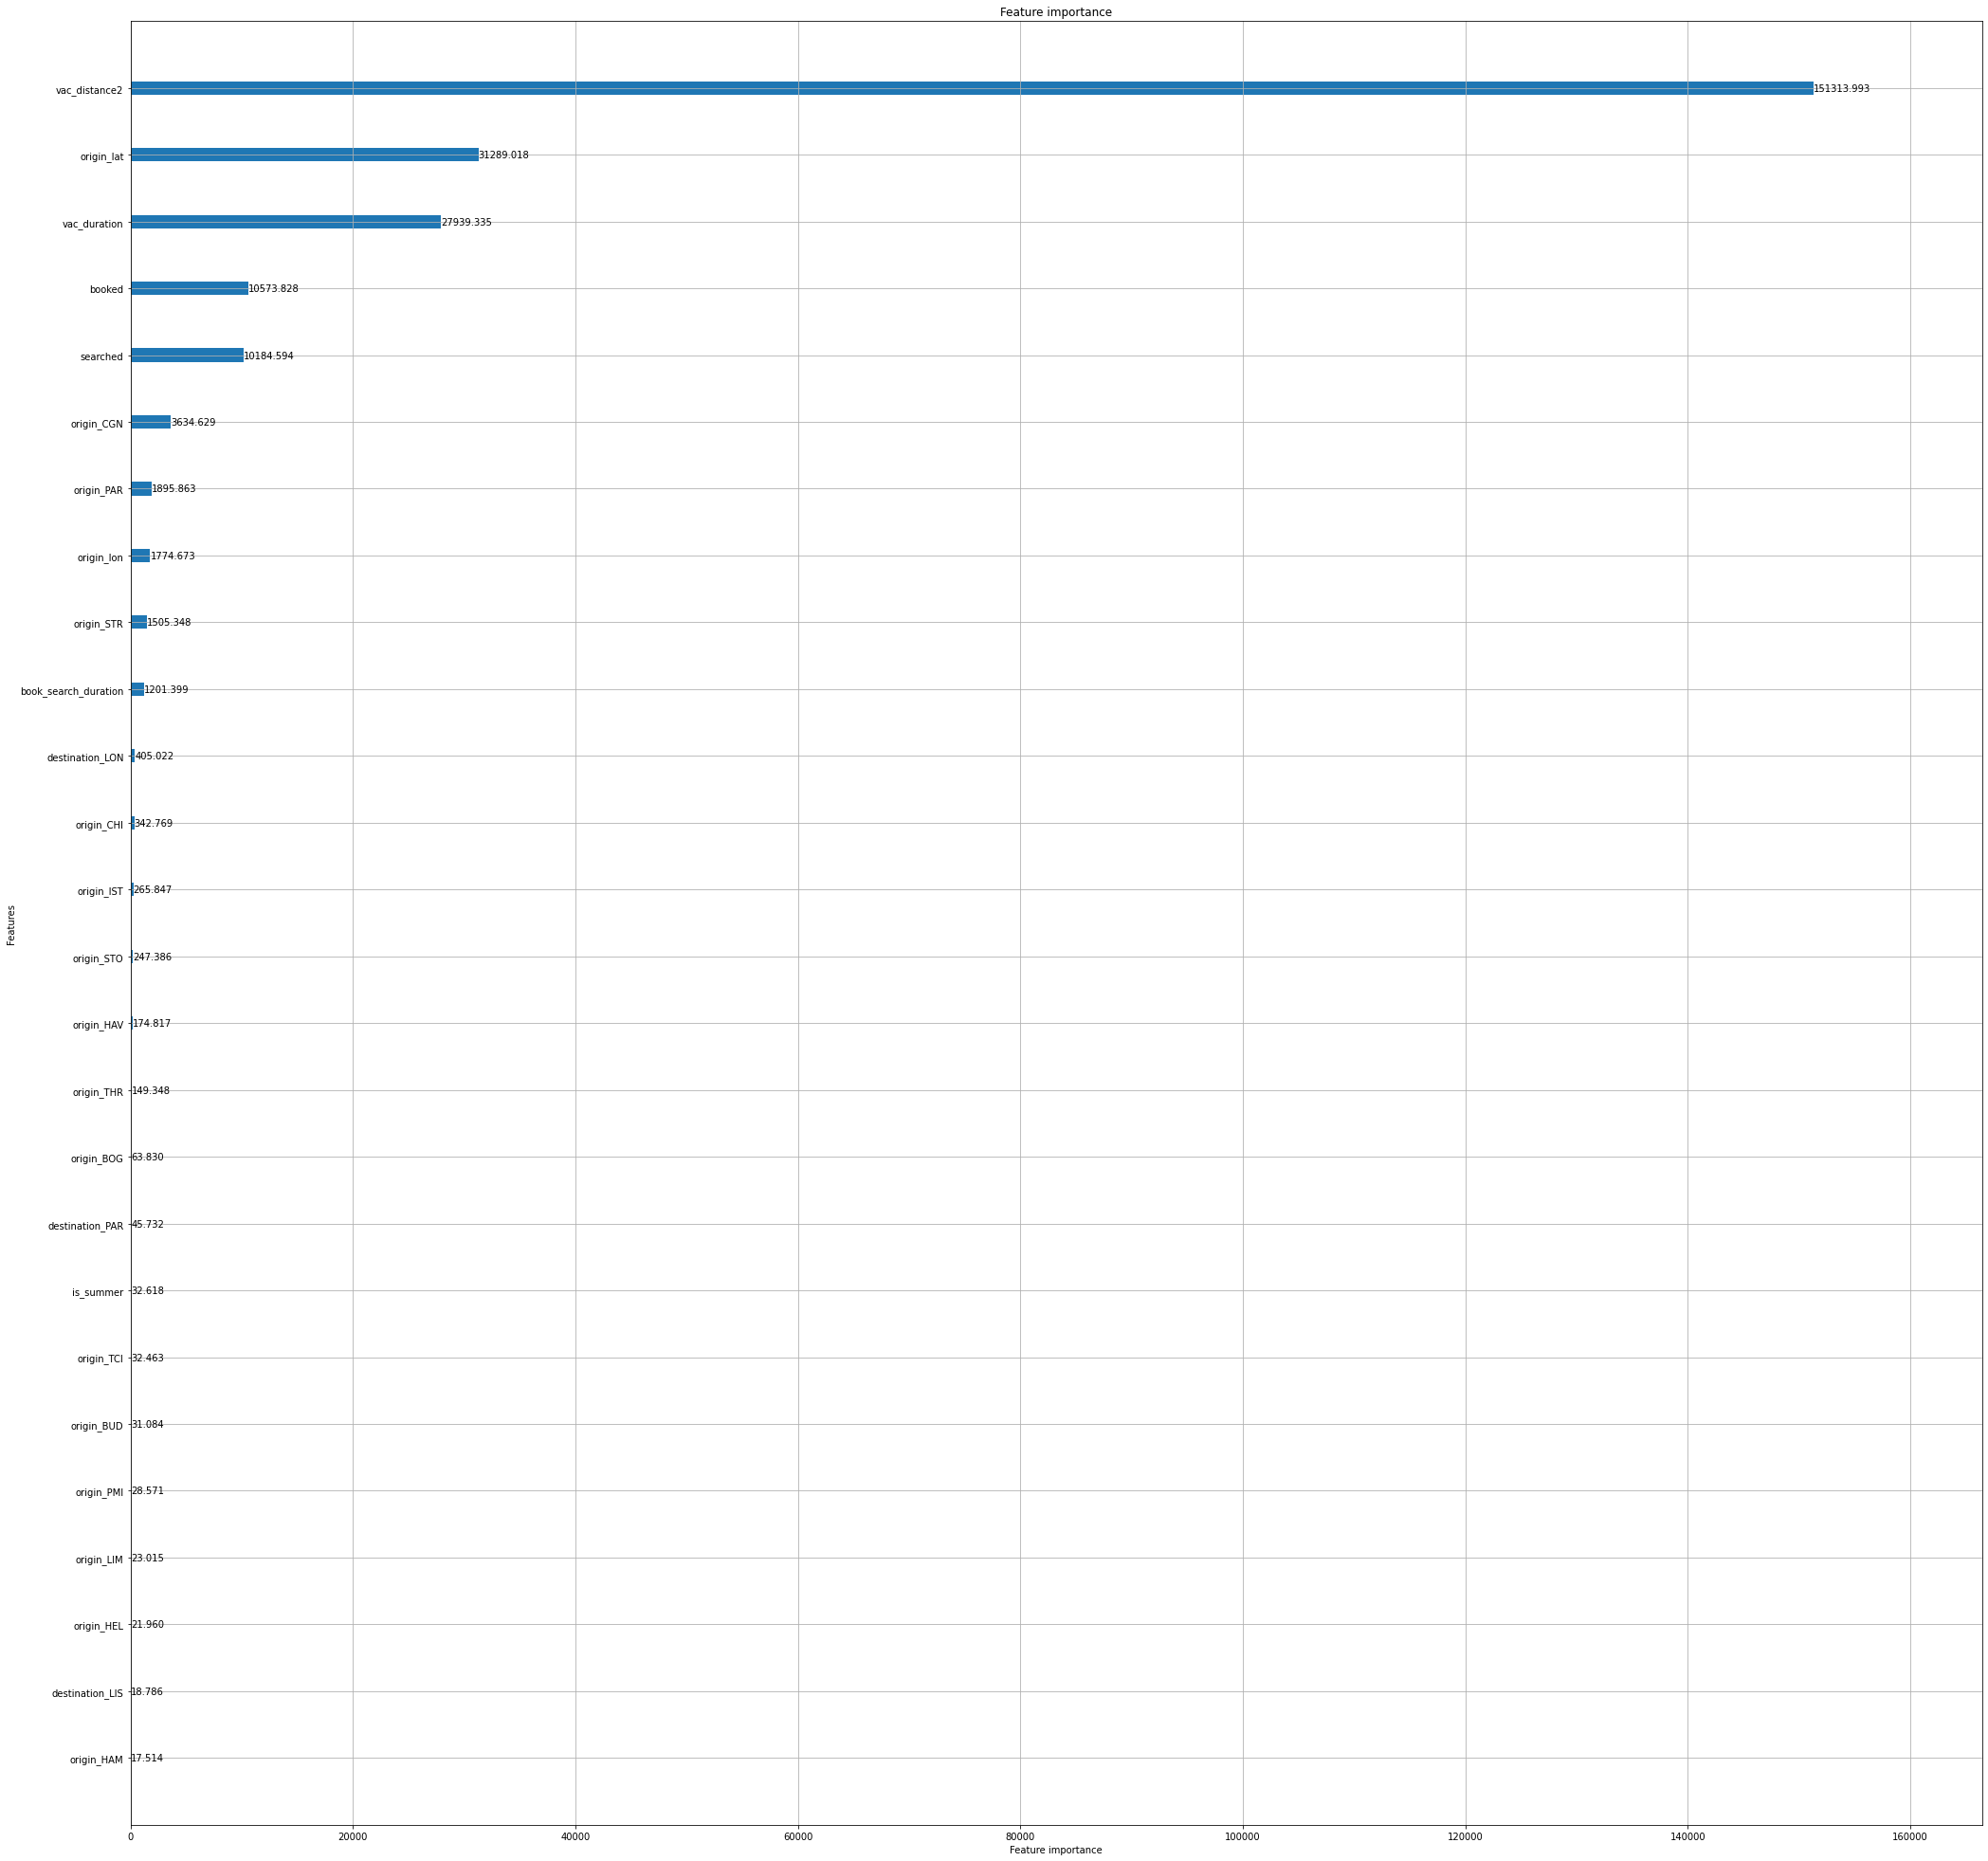

In [11]:
lightgbm.plot_importance(bst, importance_type='gain', figsize=(35, 35))

## Evaluation

In [12]:
#ROC AUC Score Train
y_hat = bst.predict(X_train)
auc_train=roc_auc_score(y_score=y_hat, y_true=y_train)
print(auc_train)

0.9037213844383987


In [13]:
#ROC AUC Score Validation
y_hat = bst.predict(X_val)
auc_val=roc_auc_score(y_score=y_hat, y_true=y_val)
print(auc_val)


0.8911943481738203


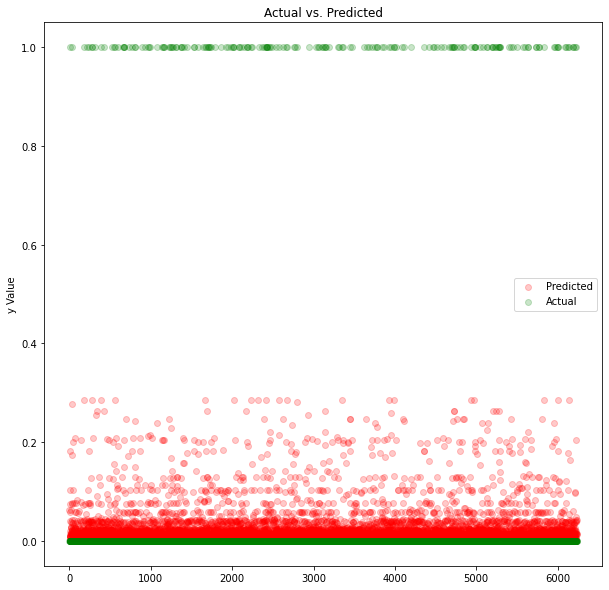

In [14]:
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x = range(0, y_hat.size), y=y_hat, c = 'red', label = 'Predicted', alpha = 0.21)
ax.scatter(x = range(0, y_val.size), y=y_val, c = 'green', label = 'Actual', alpha = 0.21)
plt.title('Actual vs. Predicted')
plt.ylabel('y Value')
plt.legend()
plt.show()

In [15]:

print(f"Minimum predicted booking likelihood is %{(y_hat.min()*100):1.7f} maximum predicted booking likelihood is %{(y_hat.max()*100):1.7f}")

Minimum predicted booking likelihood is %0.6126752 maximum predicted booking likelihood is %28.5860172


In [27]:
#RMSE Train
y_hat = bst.predict(X_train)
rms_train = mean_squared_error(y_train, y_hat)
print(rms_train)

0.02369690714547768


In [28]:
#RMSE Validation
y_hat = bst.predict(X_val)
rms_val = mean_squared_error(y_val, y_hat)
print(rms_val)

0.024569984436613023


In [18]:
#Binary y_hat values
y_bins=[]
for y in y_hat:
    if y<0.5:
        y_bin=0
    else:
        y_bin=1
    y_bins.append(y_bin)
        

In [19]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_bins)
tp=cm[0][0]
fp=cm[1][0]
tn=cm[1][1]
fn=cm[0][1]
print(cm)

[[6050    0]
 [ 186    0]]


In [20]:
#Precision
precision=(tp/(tp+fp))
print(f"Precision for validation dataset is {precision:1.5f}")

Precision for validation dataset is 0.97017


In [21]:
#Accuracy
accuracy=(tp+tn)/(tp+tn+fp+fn)
print(f"Accuracy for validation dataset is {accuracy:1.5f}")

Accuracy for validation dataset is 0.97017


In [29]:
print(f"For validation dataset: AUC is {auc_val:1.5f}, rmse is {rms_val:1.5f}, precision is {precision:1.5f}, accuracy is {accuracy:1.5f} ")

For validation dataset: AUC is 0.89119, rmse is 0.02457, precision is 0.97017, accuracy is 0.97017 


## Cross Validation

In [22]:
cv_results = lightgbm.cv(param, dtrain, num_boost_round=1500, nfold=10, early_stopping_rounds=50,stratified=False)

In [23]:
cv_results=cv_results["binary_logloss-mean"]
print(cv_results)

[0.13193528537773205, 0.13190339813009982, 0.13190200585672782, 0.13188441170570472, 0.13159241551325646, 0.13130754255353722, 0.13102756450085082, 0.13097489491512965, 0.13095576768349018, 0.13092404584098372, 0.13089260816973827, 0.1308619686013478, 0.13082274579828465, 0.13076921419919624, 0.1307502105672552, 0.1307359113354166, 0.13072174906908876, 0.13066801732189004, 0.1306153548031295, 0.13057487948972074, 0.13056687315518223, 0.1302939767192875, 0.1300327217608455, 0.13001929687683975, 0.1299781685390284, 0.12992729055383276, 0.1298972713641524, 0.12986770360919747, 0.12985562321907776, 0.12959739826316108, 0.12957810270727907, 0.1293248999206071, 0.12929472049615945, 0.12927848031937658, 0.12923983532798478, 0.12899220579739654, 0.1289548764537422, 0.12894107022794185, 0.1289115137637185, 0.12887311689942602, 0.12885683698679257, 0.12882691581199218, 0.12858257308777626, 0.12853253478458676, 0.12849387167630838, 0.12844399466631223, 0.12840788922015428, 0.1283708233444844, 0.1

In [24]:
#Summary of CV Results
print(f"According to cross validation results min logloss is {min(cv_results):1.7f} maximum logloss is {max(cv_results):1.7f}, average is {st.mean(cv_results):1.7f} ")

According to cross validation results min logloss is 0.0950726 maximum logloss is 0.1319353, average is 0.1056466 


<AxesSubplot:>

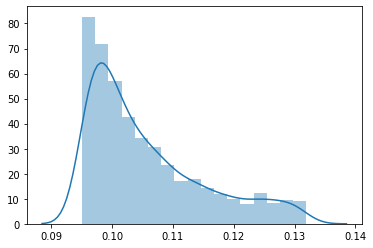

In [25]:
#Distribution of CV Results
sns.distplot(cv_results)

In [26]:
cv_results=pd.DataFrame(cv_results)
cv_results.describe()

,0
count,1500.000000
mean,0.105647
std,0.009481
min,0.095073
25%,0.098143
50%,0.102453
75%,0.110575
max,0.131935
